- Họ tên - mã số sinh viên:
  - Sinh viên 1: Võ Minh Trí - 19522396
  - Sinh viên 2: Vũ Hữu Tùng - 19522497
  - Sinh viên 3: Nguyễn Thị Mai Phương - 19522064 
- Môn: Xử Lý Ngôn Ngữ Tự Nhiên Cho Khoa Học Dữ Liệu 
- Tên Đồ Án Môn Học: Vietnamese Text Summarization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## đọc dữ liệu

In [2]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/Năm 3/NLP/Do_An/dataset/dataset/data_train.csv', encoding='utf-8')
df_dev = pd.read_csv('/content/drive/MyDrive/Năm 3/NLP/Do_An/dataset/dataset/data_val.csv', encoding='utf-8')
df_test = pd.read_csv('/content/drive/MyDrive/Năm 3/NLP/Do_An/dataset/dataset/test_data.csv', encoding='utf-8')


In [3]:
#so sanh
set_test = pd.read_csv('/content/drive/MyDrive/Năm 3/NLP/Do_An/dataset/dataset/test_data.csv', encoding='utf-8')

In [4]:
set_test = set_test.drop(['Unnamed: 0', 'file'], axis=1)

In [ ]:
# set_test = set_test[0:10000]

In [5]:
df_train = df_train.drop(['Unnamed: 0', 'file'], axis=1)
df_dev = df_dev.drop(['Unnamed: 0', 'file'], axis=1)
df_test = df_test.drop(['Unnamed: 0', 'file'], axis=1)

In [ ]:
#df_train = df_train[0:50000]
#df_dev = df_dev[0:10000]
# data_20k = train_df[0:20000]
# df_test = df_test[0:10000]

In [6]:
df_train = df_train[0:50000]
df_dev = df_dev[0:20000]
# data_20k = train_df[0:20000]
#df_test = df_test[0:20000]
#df_test_1 = df_test[20000:22644]

In [69]:
set_test = set_test[0:10000]

In [7]:
df_test.shape

(22644, 2)

In [8]:
df_test.head(2)

,original,summary
0,HMS Queen_Elizabeth thử_nghiệm trên biển hồi n...,Bộ_trưởng Quốc_phòng Anh vạch ra chiến_lược hậ...
1,Bộ_trưởng Công_Thương_Trần_Tuấn_Anh vừa kỷ_luậ...,Nhận kỷ_luật sau khi đi lễ trong giờ_hành_chín...


In [9]:
df_train['summary'][1]

'USS Michigan , tàu_ngầm hạt_nhân Mỹ tới cảng Busan của Hàn_Quốc giữa khi căng_thẳng leo_thang trên bán_đảo Triều_Tiên . Động_thái này được cho là nhằm gia_tăng áp_lực lên Bình_Nhưỡng . '

## pretrained

In [10]:
#Add sostok and eostok at 
# post_pre_train = df_train
# post_pre_dev = df_dev
# post_pre_test = df_test
df_train['summary'] = df_train['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_dev['summary'] = df_dev['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_test['summary'] = df_test['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [11]:
!pip install pyvi

     |████████████████████████████████| 8.5 MB 5.1 MB/s 
     |████████████████████████████████| 743 kB 62.1 MB/s 


In [12]:
# Extract word vectors
import numpy as np
embeddings_index = {}
f = open('/content/drive/MyDrive/Năm 3/NLP/Do_An/Glove_attention_layer/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from keras.preprocessing.text import Tokenizer

max_len = 100

word_tokenizer = Tokenizer(oov_token=-1)
word_tokenizer.fit_on_texts(df_train.original.values.flatten())
word_to_index = word_tokenizer.word_index
word_to_index['pad'] = 0
word_to_index['unk'] = -1

index_to_word = {i: w for w, i in word_to_index.items()}

def encodingx(X):
    sentences = []
    
    for t in X:
        tokenized_sentence = ViTokenizer.tokenize(t)
        sentences.append(tokenized_sentence)
    
    X = word_tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index['pad'])

    return X

In [14]:
word_to_index['tôi']

86

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from keras.preprocessing.text import Tokenizer

max_len = 100

yword_tokenizer = Tokenizer(oov_token=-1)
yword_tokenizer.fit_on_texts(df_train.summary.values.flatten())
yword_to_index = yword_tokenizer.word_index
yword_to_index['pad'] = 0
yword_to_index['unk'] = -1

yindex_to_word = {i: w for w, i in yword_to_index.items()}

def encodingy(X):
    sentences = []
    
    for t in X:
        tokenized_sentence = ViTokenizer.tokenize(t)
        sentences.append(tokenized_sentence)
    
    X = yword_tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = yword_to_index['pad'])

    return X

In [16]:
# first create a matrix of zeros, this is our embedding matrix
import numpy as np

embedding_dim = 100
max_feature = len(embeddings_index) + 2
num_words = len(word_to_index)
embedding_matrixX = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_to_index.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrixX[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrixX[i] = np.random.randn(embedding_dim)

In [17]:
# first create a matrix of zeros, this is our embedding matrix
ynum_words = len(yword_to_index)
embedding_matrixy = np.zeros((ynum_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in yword_to_index.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrixy[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrixy[i] = np.random.randn(embedding_dim)

In [18]:
# X_train_encoded = encoding(X_train)
# X_dev_encoded = encoding(X_dev)
# X_test_encoded = encoding(X_test)

X_train_encoded = encodingx(df_train.original.values.flatten())
y_train_encoded = encodingy(df_train.summary)
X_dev_encoded = encodingx(df_dev.original.values.flatten())
y_dev_encoded = encodingy(df_dev.summary)
X_test_encoded = encodingx(df_test.original.values.flatten())
y_test_encoded = encodingy(df_test.summary)

In [19]:
y_test_encoded[0]

array([   2,   35,  157,   19,  127,  141, 3026,   29,  161, 1044,  455,
       2504,  146,  125, 2409,  707,  518,  314,   85,   66,   24,  223,
        449,  505, 1249,    4, 1540,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

array([[   2,   33,  155, ...,    0,    0,    0],
       [   2,  114,  500, ...,    0,    0,    0],
       [   2,  122,  282, ...,    0,    0,    0],
       ...,
       [   2,  340, 1712, ...,    0,    0,    0],
       [   2,   39, 1328, ...,    0,    0,    0],
       [   2,  108,  536, ...,    0,    0,    0]], dtype=int32)

## build model

In [20]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from keras.initializers import Constant
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
num_wordsX = len(word_to_index)
num_wordsy = len(yword_to_index)

print("Size of vocabulary from the w2v model = {}".format(num_wordsX))
MAX_LEN=100
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(MAX_LEN, ))

#embedding layer
enc_emb =  Embedding(input_dim=num_wordsX, 
                     output_dim=embedding_dim,
                     embeddings_initializer=Constant(embedding_matrixX),
                     trainable=True,
                     input_length = MAX_LEN
                     
                     )(encoder_inputs)
#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(input_dim=num_wordsy,
                          output_dim=embedding_dim,
                          trainable=True,
                          embeddings_initializer=Constant(embedding_matrixy),
                          input_length=MAX_LEN)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(num_wordsy, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 89020
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     8902000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                

In [ ]:
embedding_matrixX.shape

(89020, 100)

In [ ]:
X_train_encoded.shape

(80000, 100)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


## visualize model

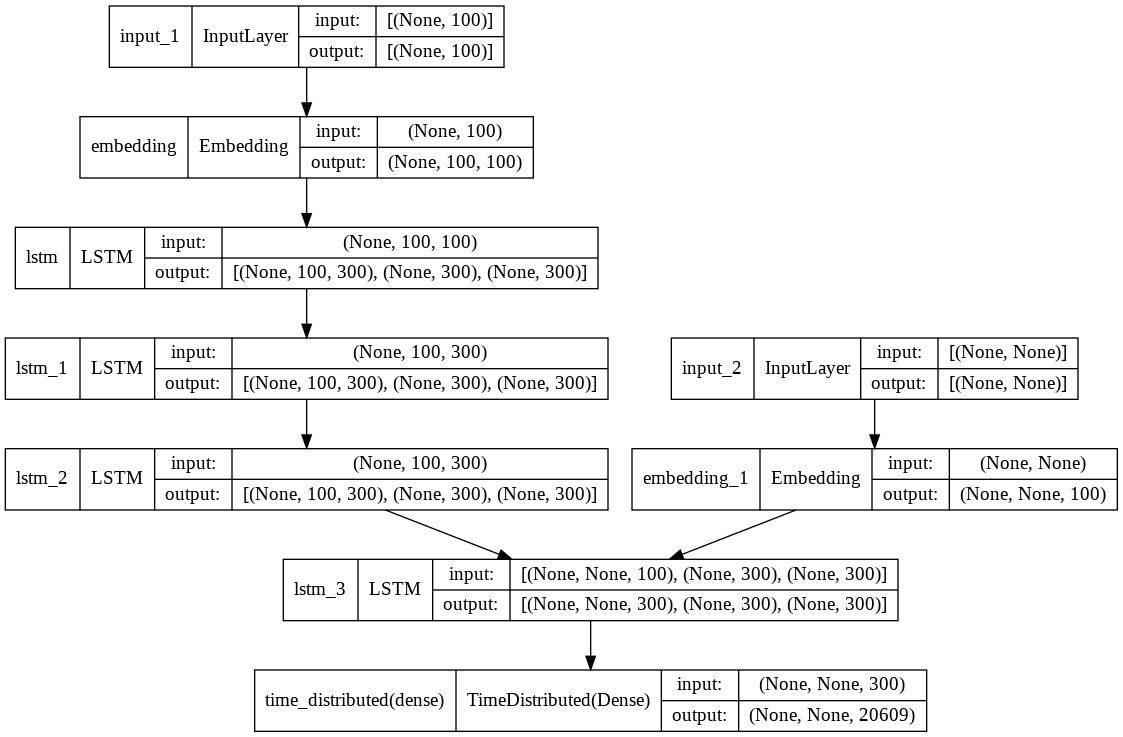

In [ ]:
#Visualize the Model
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Train model

In [ ]:
# history=model.fit(x_tr, y_tr,epochs=50,callbacks=[es],batch_size=128, validation_data=(x_val,y_val))

# history=model.fit([X_train_encoded,y_train_encoded[:,:]], y_train_encoded.reshape(y_train_encoded.shape[0],y_train_encoded.shape[1], 1)[:,1:] ,
#                   epochs=50,callbacks=[es],
#                   batch_size=256, 
#                   validation_data=([X_dev_encoded,y_dev_encoded[:,:]], y_dev_encoded.reshape(y_dev_encoded.shape[0],y_dev_encoded.shape[1], 1)[:,1:]))

history=model.fit([X_train_encoded,y_train_encoded[:,:-1]], y_train_encoded.reshape(y_train_encoded.shape[0],y_train_encoded.shape[1], 1)[:,1:] ,
                  epochs=50,callbacks=[es],
                  batch_size=256, 
                  validation_data=([X_dev_encoded,y_dev_encoded[:,:-1]], y_dev_encoded.reshape(y_dev_encoded.shape[0],y_dev_encoded.shape[1], 1)[:,1:]))



Epoch 1/50
313/313 [==============================] - 508s 2s/step - loss: 2.5034 - val_loss: 2.1043
Epoch 2/50
313/313 [==============================] - 498s 2s/step - loss: 2.0227 - val_loss: 1.8887
Epoch 3/50
313/313 [==============================] - 500s 2s/step - loss: 1.8748 - val_loss: 1.7891
Epoch 4/50
313/313 [==============================] - 500s 2s/step - loss: 1.7922 - val_loss: 1.7224
Epoch 5/50
313/313 [==============================] - 501s 2s/step - loss: 1.7347 - val_loss: 1.6752
Epoch 6/50
313/313 [==============================] - 502s 2s/step - loss: 1.6909 - val_loss: 1.6406
Epoch 7/50
313/313 [==============================] - 503s 2s/step - loss: 1.6560 - val_loss: 1.6144
Epoch 8/50
313/313 [==============================] - 503s 2s/step - loss: 1.6275 - val_loss: 1.5877
Epoch 9/50
313/313 [==============================] - 503s 2s/step - loss: 1.6030 - val_loss: 1.5679
Epoch 10/50
313/313 [==============================] - 503s 2s/step - loss: 1.5827 - val_lo

##decode

In [31]:
reverse_target_word_index=yword_tokenizer.index_word
reverse_source_word_index=word_tokenizer.index_word
target_word_index=yword_tokenizer.word_index

In [32]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(MAX_LEN,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
with open('/content/drive/MyDrive/Năm 3/NLP/Do_An/Glove_not_attention_layer/encoder_50_model_not_attention.json', 'w', encoding='utf8') as f:
    f.write(encoder_model.to_json())
encoder_model.save_weights('/content/drive/MyDrive/Năm 3/NLP/Do_An/Glove_not_attention_layer/encoder_model_50_seq2seq_vitokenizer_not_attention.h5')

with open('/content/drive/MyDrive/Năm 3/NLP/Do_An/Glove_not_attention_layer/decoder_50_model_not_attention.json', 'w', encoding='utf8') as f:
    f.write(decoder_model.to_json())
decoder_model.save_weights('/content/drive/MyDrive/Năm 3/NLP/Do_An/Glove_not_attention_layer/decoder_model_50_seq2seq_vitokenizer_not_attention.h5')
#/content/drive/MyDrive/Năm 3/NLP/Do_An/dataset/dataset/data_train.csv

**We are defining a function below which is the implementation of the inference process**

In [33]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (100-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [34]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+str(reverse_target_word_index[i])+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+str(reverse_source_word_index[i])+' '
    return newString

**Run the model over the data to see the results**

### predict

In [35]:
!pip install rouge-score -qq

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
for i in range(0,10):
    print("Review:",seq2text(X_test_encoded[i]))
    print("Original summary:",seq2summary(y_test_encoded[i]))
    print("Predicted summary:",decode_sequence(X_test_encoded[i].reshape(1,100)))
    scores = scorer.score(seq2summary(y_test_encoded[i]), decode_sequence(X_test_encoded[i].reshape(1,100)))
    print(scores)
    print("\n")


Review: kiến được trang bị hệ thống phóng và cáp hãm đà cho máy bay như lớp nimitz và gerald r ford của mỹ nhưng chi phí quá cao buộc hải quân anh lựa chọn giải pháp stovl và sử dụng tiêm kích f 35 b hms queen elizabeth có khả năng chở tối đa 36 máy bay f 35 b và 4 trực thăng cảnh báo sớm crowsnest nó có thể được bổ sung tới 12 trực thăng chinook hoặc merlin và 8 trực thăng tấn công ah 64 apache hms queen elizabeth thử nghiệm trên biển hồi năm 2018 
Original summary: bộ trưởng quốc phòng anh vạch ra chiến lược hậu brexit đề cao phô trương sức mạnh quân sự để bảo vệ lợi ích của london 
Predicted summary:  hải quân mỹ đang tìm cách nâng cấp hệ thống phòng không tầm xa và khả năng chiến đấu cơ f 35 a của mỹ
{'rouge1': Score(precision=0.5, recall=0.5, fmeasure=0.5), 'rouge2': Score(precision=0.10810810810810811, recall=0.10810810810810811, fmeasure=0.10810810810810811), 'rougeL': Score(precision=0.3157894736842105, recall=0.3157894736842105, fmeasure=0.3157894736842105)}


Review: giờ làm 

In [70]:
set_test.summary[0:10]

0                                                                                Bộ_trưởng Quốc_phòng Anh vạch ra chiến_lược hậu Brexit , đề_cao phô_trương sức_mạnh quân_sự để bảo_vệ lợi_ích của London . 
1    Nhận kỷ_luật sau khi đi lễ trong giờ_hành_chính , Giám_đốc trung_tâm hỗ_trợ xuất_khẩu ( Cục Xúc_tiến thương_mại ) bị hạ bậc lương . Hội_đồng_kỷ_luật cũng cảnh_cáo 7 cán_bộ cấp phòng , khiển_trách ...
2           Theo quy_định của luật Khiếu_nại , các cơ_quan Nhà_nước có thẩm_quyền không được thụ_lý giải_quyết đối_với khiếu_nại đã có quyết_định giải_quyết lần 2 . Việc này thuộc thẩm_quyền của toà_án . 
3                                                                  Ngày mùng 3 Tết , phố Sách Hà_Nội mở_cửa và sẽ kéo_dài tới ngày mùng 10 tế và đây trở_thành một điểm đến của nhiều gia_đình đi du_xuân . 
4                                                                            Một cặp vợ_chồng tại thành_phố Hamburg , Đức đã lơ_đễnh quên mất đứa con vừa chào_đời của họ khi đi tax

In [71]:
len(set_test.summary)

10000

In [72]:
len(df_test)

22644

In [ ]:
from rouge_score import rouge_scorer
#scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
df_predict_test = []
for i in range(len(set_test.summary)):
    # print("Review:",seq2text(X_test_encoded[i]))
    # print("Original summary:",seq2summary(y_test_encoded[i]))
    # print("Predicted summary:",decode_sequence(X_test_encoded[i].reshape(1,100)))
    df_predict_test.append(decode_sequence(X_test_encoded[i].reshape(1,100)))
    #scores = scorer.score(set_test.summary[i], decode_sequence(X_test_encoded[i].reshape(1,100)))
    print(i)

Streaming output truncated to the last 5000 lines.
17644
17645
17646
17647
17648
17649
17650
17651
17652
17653
17654
17655
17656
17657
17658
17659
17660
17661
17662
17663
17664
17665
17666
17667
17668
17669
17670
17671
17672
17673
17674
17675
17676
17677
17678
17679
17680
17681
17682
17683
17684
17685
17686
17687
17688
17689
17690
17691
17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
1

In [ ]:
import pandas as pd

df_predict_test = pd.DataFrame(df_predict_test, columns = ['predict'])

In [ ]:
df_predict_test.to_csv('/content/drive/MyDrive/Năm 3/NLP/Do_An/predict_full_not_attention.csv', encoding='utf-8')

In [ ]:
from keras.models import model_from_json

# Load model and Predict

In [39]:
from keras.models import model_from_json

In [ ]:
def load_model(model_filename, model_weights_filename):
    with open(model_filename, 'r', encoding='utf8') as f:
        model = model_from_json(f.read())
    model.load_weights(model_weights_filename)
    return model

encoder = load_model('/content/drive/MyDrive/Năm 3/NLP/Do_An/Glove_not_attention_layer/encoder_50_model_not_attention.json', '/content/drive/MyDrive/Năm 3/NLP/Do_An/Glove_not_attention_layer/encoder_model_50_seq2seq_vitokenizer_not_attention.h5')
decoder = load_model('/content/drive/MyDrive/Năm 3/NLP/Do_An/Glove_not_attention_layer/decoder_50_model_not_attention.json', '/content/drive/MyDrive/Năm 3/NLP/Do_An/Glove_not_attention_layer/decoder_model_50_seq2seq_vitokenizer_not_attention.h5')

In [26]:
reverse_target_word_index=yword_tokenizer.index_word
reverse_source_word_index=word_tokenizer.index_word
target_word_index=yword_tokenizer.word_index

In [40]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+str(sampled_token)

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (100-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [41]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+str(reverse_target_word_index[i])+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+str(reverse_source_word_index[i])+' '
    return newString

In [29]:
!pip install -q rouge_score

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
for i in range(0,10):
    print("Review:",seq2text(X_test_encoded[i]))
    print("Original summary:",seq2summary(y_test_encoded[i]))
    print("Predicted summary:",decode_sequence(X_test_encoded[i].reshape(1,100)))
    scores = scorer.score(seq2summary(y_test_encoded[i]), decode_sequence(X_test_encoded[i].reshape(1,100)))
    print(scores)
    print("\n")

In [57]:
!pip install rouge_score

In [73]:
import pandas as pd
data_pred = pd.read_csv('/content/drive/MyDrive/Năm 3/NLP/Do_An/Glove_not_attention_layer/predict_full_not_attention.csv')
data_pred.head(5)

,Unnamed: 0,predict
0,0,hải quân mỹ đang tìm cách nâng cấp hệ thống phòng không tầm xa và khả năng chiến đấu cơ f 35 a của mỹ
1,1,thủ tướng chính phủ yêu cầu bộ xây dựng đề nghị bộ trưởng bộ nội vụ xem xét xử lý nghiêm minh cán bộ đảng viên chức vụ
2,2,sau khi toà án nhân dân tp hcm đã tuyên án khởi tố vụ án khởi tố bị can nguyễn hữu linh nguyên giám đốc công ty cổ phần truyện việt nam tp hcm cho biết đã có quyết định khởi tố vụ án khởi tố bị c...
3,3,chiều nay 28 5 các nhà khoa học tp hcm đã có những chia sẻ về những ngày tết kỷ hợi 2019 với những người trẻ trong đó có nhiều người trẻ
4,4,bé gái 5 tuổi ở tp hcm đã bị xe tải đâm vào xe máy rồi lao vào lan can rồi bỏ chạy


In [77]:
data_pred.shape

(10000, 2)

In [76]:
data_pred = data_pred[0:10000]

In [78]:
set_test.iloc[:,1][1]

'Nhận kỷ_luật sau khi đi lễ trong giờ_hành_chính , Giám_đốc trung_tâm hỗ_trợ xuất_khẩu ( Cục Xúc_tiến thương_mại ) bị hạ bậc lương . Hội_đồng_kỷ_luật cũng cảnh_cáo 7 cán_bộ cấp phòng , khiển_trách 2 viên_chức . '

In [79]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
list_score = []
for i in range(0,len(set_test)):
    scores = scorer.score(data_pred.iloc[:,1][i],set_test.iloc[:,1][i] )
    list_score.append(scores)
    print(scores)

Streaming output truncated to the last 5000 lines.
{'rouge1': Score(precision=0.40476190476190477, recall=0.5862068965517241, fmeasure=0.4788732394366197), 'rouge2': Score(precision=0.07317073170731707, recall=0.10714285714285714, fmeasure=0.08695652173913043), 'rougeL': Score(precision=0.23809523809523808, recall=0.3448275862068966, fmeasure=0.2816901408450704)}
{'rouge1': Score(precision=0.4461538461538462, recall=0.6170212765957447, fmeasure=0.5178571428571428), 'rouge2': Score(precision=0.140625, recall=0.1956521739130435, fmeasure=0.16363636363636366), 'rougeL': Score(precision=0.26153846153846155, recall=0.3617021276595745, fmeasure=0.3035714285714286)}
{'rouge1': Score(precision=0.3684210526315789, recall=0.20588235294117646, fmeasure=0.2641509433962264), 'rouge2': Score(precision=0.05555555555555555, recall=0.030303030303030304, fmeasure=0.0392156862745098), 'rougeL': Score(precision=0.2631578947368421, recall=0.14705882352941177, fmeasure=0.18867924528301885)}
{'rouge1': Score

In [80]:
list_score_r1 = []
list_score_r2 = []
list_score_rl = []
for i in range(len(set_test)):
  list_score_r1.append(list_score[i]['rouge1'].fmeasure)
  list_score_r2.append(list_score[i]['rouge2'].fmeasure)
  list_score_rl.append(list_score[i]['rougeL'].fmeasure)

In [81]:
np.mean(list_score_r1)

0.4788202566496554

In [82]:
np.mean(list_score_r2)

0.12463535567907692

In [83]:
np.mean(list_score_rl)

0.28659180239090815

In [84]:
list_score_r1_pre = []
list_score_r2_pre = []
list_score_rl_pre = []
for i in range(len(set_test)):
  list_score_r1_pre.append(list_score[i]['rouge1'].precision)
  list_score_r2_pre.append(list_score[i]['rouge2'].precision)
  list_score_rl_pre.append(list_score[i]['rougeL'].precision)

In [85]:
np.mean(list_score_r1_pre)

0.45803708772229373

In [86]:
np.mean(list_score_r2_pre)

0.11868098072823732

In [87]:
np.mean(list_score_rl_pre)

0.2743474583297729

In [88]:
list_score_r1_recall = []
list_score_r2_recall = []
list_score_rl_recall = []
for i in range(len(set_test)):
  list_score_r1_recall.append(list_score[i]['rouge1'].recall)
  list_score_r2_recall.append(list_score[i]['rouge2'].recall)
  list_score_rl_recall.append(list_score[i]['rougeL'].recall)

In [89]:
print(np.mean(list_score_r1_recall))
print(np.mean(list_score_r2_recall))
print(np.mean(list_score_rl_recall))

0.5304960289983978
0.13914617124432763
0.31875140229541654
